<a href="https://colab.research.google.com/github/JinFree/PDE-for-CFD-in-Python/blob/master/Parabolic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parabolic PDE

## 확산방정식

* 확산방정식의 형태는 아래와 같음.
\begin{equation}
\frac{\partial{u}}{\partial{y}} = \nu \frac{\partial^{2}{u}}{\partial{y}^{2}}
\end{equation}
* Explicit FTCS 방법으로 푸는 예제임
 * FT = Forward Time
\begin{equation}
\frac{\partial{u}}{\partial{y}} = \frac{u_{i}^{n+1}-u_{i}^{n}}{\triangle{t}}
\end{equation}
 * CS = Central Space
\begin{equation}
\nu\frac{\partial^{2}{u}}{\partial{y}^{2}} = \nu\frac{u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n}}{{\triangle{y}}^2}
\end{equation}
* 정리하면 아래와 같음
\begin{equation}
u_{i}^{n+1} = du_{i+1}^{n} + (1-2d)u_{i}^{n}+du_{i-1}^{n}
\end{equation}
\begin{equation}
d = \frac{\nu\triangle{t}}{{\triangle{y}}^2}
\end{equation}
* 위의 방정식을 아래와 같은 조건으로 풀이함.
 * 환경 조건
\begin{equation}
0m<y<0.04m
\end{equation}
\begin{equation}
\nu = 0.000217m^2/s
\end{equation}
\begin{equation}
\triangle{t}=0.000001s
\end{equation}
\begin{equation}
\triangle{y}=0.001m
\end{equation}
 * 초기값 조건
\begin{equation}
u_{t=0} = 0m/s
\end{equation}
 * 경계 조건
\begin{equation}
u_{h=0m} = 40m/s
\end{equation}
\begin{equation}
u_{h=0.04m}=0m/s
\end{equation}


## 확산방정식 풀이를 위한 모듈 불러오기

In [0]:
import numpy as np

## 주어진 조건에 따른 기본 변수 설정

In [23]:
h = 0.04
nu = 0.000217
dy = 0.00001
dt = 0.0000001
u0 = 40.0
d = nu * dt / ( dy * dy )
t_end = 0.005
iteration = int(t_end / dt)
time = 0.0
number_of_grids = int(h / dy) + 1
U = np.zeros(number_of_grids, dtype=np.float32)
Unew = np.zeros(number_of_grids, dtype=np.float32)
print("Grid size is %"%number_of_grids)
print("Diffusion number is %.4f"%d)

Diffusion number is 0.2170


## 초기값 설정

In [0]:
def initial_condition(U, Unew):
    U = np.zeros(number_of_grids)
    Unew = np.zeros(number_of_grids)
    return U, Unew

## 경계 조건 설정

In [0]:
def boundary_condition(U, Unew):
    U[0] = Unew[0] = u0
    return U, Unew

## FTCS 연산 함수

In [0]:
def FTCS_Numpy(U, Unew, diffusion):
    for i in range(1, len(U)-1, 1):
        Unew[i] = diffusion * (U[i-1] + U[i+1]) + (1.0 - 2.0 * diffusion) * U[i]
    return Unew

def Explicit_Solver(U, Unew, diffusion, iteration, time):
    for i in range(iteration + 1):
        FTCS_Numpy(U, Unew, diffusion)
        U[0] = Unew[0] = u0
        U = np.copy(Unew)
        time += dt
    return U

## CPU기반 Numpy를 이용한 풀이 함수

In [0]:
def Parabolic_Numpy_CPU(U, Unew, diffusion, iteration, time):
    U, Unew = initial_condition(U, Unew)
    U, Unew = boundary_condition(U, Unew)
    U = Explicit_Solver(U, Unew, diffusion, iteration, time)
    return U
U_numpy_cpu = Parabolic_Numpy_CPU(U, Unew, d, iteration, time)

## 연산 결과를 plotting 하기 위한 함수

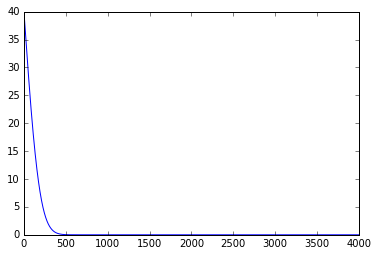

In [26]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
def plot(U):
    fig = plt.figure()
    plt.plot(U)
plot(U_numpy_cpu)

## Numba CPU를 이용한 함수

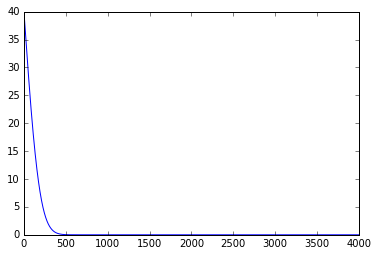

In [27]:
import numba

@numba.stencil
def _FTCS_Numba(U, diffusion):
    return diffusion * (U[-1] + U[1]) + (1.0 - 2.0 * diffusion) * U[0]

@numba.njit
def FTCS_Numba(U, Unew, diffusion):
    Unew = _FTCS_Numba(U, diffusion)
    return Unew

def Explicit_Solver_numba_cpu(U, Unew, diffusion, iteration, time):
    for i in range(iteration + 1):
        Unew = FTCS_Numba(U, Unew, diffusion)
        U[0] = Unew[0] = u0
        U = np.copy(Unew)
        time += dt
    return U

def Parabolic_Numba_CPU(U, Unew, diffusion, iteration, time):
    U, Unew = initial_condition(U, Unew)
    U, Unew = boundary_condition(U, Unew)
    U = Explicit_Solver_numba_cpu(U, Unew, diffusion, iteration, time)
    return U
U_numba_cpu = Parabolic_Numba_CPU(U, Unew, d, iteration, time)
plot(U_numba_cpu)

## Numba GPU를 이용한 함수

In [11]:
!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'

/usr/local/cuda-10.0/nvvm/libdevice
/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so


In [0]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-10.0/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so"

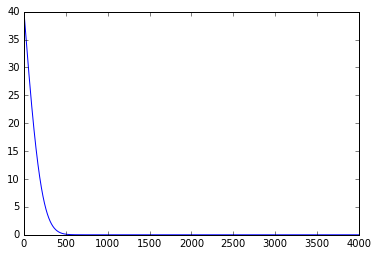

In [28]:
import numba
from numba import cuda

@cuda.jit
def FTCS_Numba_cuda(U, Unew, diffusion):
    start = cuda.grid(1)
    stride = cuda.gridsize(1)
    for i in range(start, U.shape[0], stride):
        if i > 0:
            if i < U.shape[0]-1:
                Unew[i] = diffusion * (U[i-1] + U[i+1]) + (1.0 - 2.0 * diffusion) * U[i]

def Explicit_Solver_numba_gpu(U, Unew, diffusion, iteration, time):
    U_device = cuda.to_device(U)
    Unew_device = cuda.to_device(Unew)
    for i in range(iteration + 1):
        FTCS_Numba_cuda(U_device, Unew_device, diffusion)
        cuda.synchronize()
        U_device = Unew_device
        time += dt
    U = U_device.copy_to_host()
    return U

def Parabolic_Numba_GPU(U, Unew, diffusion, iteration, time):
    U, Unew = initial_condition(U, Unew)
    U, Unew = boundary_condition(U, Unew)
    U = Explicit_Solver_numba_gpu(U, Unew, diffusion, iteration, time)
    return U
U_numba_gpu = Parabolic_Numba_GPU(U, Unew, d, iteration, time)
plot(U_numba_gpu)

In [29]:
%timeit U_numpy_cpu = Parabolic_Numpy_CPU(U, Unew, d, iteration, time)

1 loop, best of 3: 3min 5s per loop


In [30]:
%timeit U_numba_cpu = Parabolic_Numba_CPU(U, Unew, d, iteration, time)

1 loop, best of 3: 745 ms per loop


In [31]:
%timeit U_numba_gpu = Parabolic_Numba_GPU(U, Unew, d, iteration, time)

1 loop, best of 3: 43.5 s per loop


In [32]:
print(U_numpy_cpu-U_numba_cpu)
print(U_numpy_cpu-U_numba_gpu)

[0. 0. 0. ... 0. 0. 0.]
[ 0.00000000e+000 -2.49399292e-002 -4.98787093e-002 ... -3.48516745e-121
 -1.73063947e-121  0.00000000e+000]
